## Sagemaker example
Taken from this [tutorial](https://sagemaker-examples.readthedocs.io/en/latest/hyperparameter_tuning/tensorflow2_mnist/hpo_tensorflow2_mnist_outputs.html)

In [9]:
!pip install --upgrade boto3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 30.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.35
    Uninstalling boto3-1.26.35:
      Successfully uninstalled boto3-1.26.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.35 requires botocore==1.29.35, but you have botocore 1.29.41 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.41 which is incompatible.
You should consider upgrading via the '/home/ec

In [10]:
import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

In [11]:
sess = sagemaker.Session()
role = get_execution_role()

## Download MNIST data

In [45]:
import logging
import boto3
from botocore.exceptions import ClientError

public_bucket = "sagemaker-sample-files"
local_data_dir = "/tmp/data"

# Download training and testing data from a public S3 bucket
def download_from_s3(data_dir="/tmp/data", train=True):
    """Download MNIST dataset and convert it to numpy array

    Args:
        data_dir (str): directory to save the data
        train (bool): download training set

    Returns:
        None
    """
    # project root
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"

    # download objects
    s3 = boto3.client("s3")
    bucket = public_bucket
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return


download_from_s3(local_data_dir, True)
download_from_s3(local_data_dir, False)

In [44]:
download_from_s3("./data", True)
download_from_s3("./data", False)

In [46]:
prefix = "DEMO-mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path="./data", bucket=bucket, key_prefix=prefix)

channels = {"training": loc, "testing": loc}

## Run a Tensorflow training job
Using the `TensorFlow` estimator class to define the training job.
This will be run in a containerized environment.

### Train an MNIST model with TensorFlow

In [36]:
output_path = "s3://" + sess.default_bucket() + "/DEMO-tensorflow/mnist"

In [39]:
!pygmentize 'code/train.py'

from __future__ import print_function

import argparse
import gzip
import json
import logging
import os
import traceback

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

logging.basicConfig(level=logging.DEBUG)

# Define the model object


class SmallConv(Model):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation="relu")
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


# Decode and preprocess data
def convert_to_numpy(data_dir, images_file, labels_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    with gzi

In [ ]:
# Set local_mode to be True if you want to run the training script on the machine that runs this notebook

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.c4.xlarge"

est = TensorFlow(
    entry_point="test_train.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="2.3.1",
    model_dir=False,  # don't pass --model_dir to your training script
    py_version="py37",
    instance_type=instance_type,
    instance_count=1,
    volume_size=250,
    output_path=output_path,
    hyperparameters={
        "batch-size": 512,
        "epochs": 1,
        "learning-rate": 1e-3,
        "beta_1": 0.9,
        "beta_2": 0.999,
    },
)

In [55]:
est.fit(inputs=channels)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2022-12-31-17-32-58-176
INFO:sagemaker.local.local_session:Starting training job
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-bzavo:
    command: train
    container_name: fwdf0x10jn-algo-1-bzavo
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.eu-west-1.amazonaws.com/tensorflow-training:2.3.1-cpu-py37
    networks:
      sagemaker-local:
        aliases:
        - algo-1-bzavo
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmp9pqp1_kq/algo-1-bzavo/output:

Login Succeeded


INFO:sagemaker.local.image:image pulled: 763104351884.dkr.ecr.eu-west-1.amazonaws.com/tensorflow-training:2.3.1-cpu-py37


Creating fwdf0x10jn-algo-1-bzavo ... 
Creating fwdf0x10jn-algo-1-bzavo ... done
Attaching to fwdf0x10jn-algo-1-bzavo
fwdf0x10jn-algo-1-bzavo | 2022-12-31 17:34:12.599638: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
fwdf0x10jn-algo-1-bzavo | 2022-12-31 17:34:12.599929: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
fwdf0x10jn-algo-1-bzavo | 2022-12-31 17:34:12.632409: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
fwdf0x10jn-algo-1-bzavo | 2022-12-31 17:34:14,590 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
fwdf0x10jn-algo-1-bzavo | 2022-12-31 17:34:14,600 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
fwdf0x10jn-algo-1-bzavo | 2022-12-31 17:34:14,813 sage

RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmp9pqp1_kq/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1

In [48]:
tf_mnist_model_data = est.model_data
print("Model artifact saved at:\n", tf_mnist_model_data)

Model artifact saved at:
 s3://sagemaker-eu-west-1-636444261840/DEMO-tensorflow/mnist/tensorflow-training-2022-12-31-17-11-39-472/output/model.tar.gz


In [50]:
%store tf_mnist_model_data

Stored 'tf_mnist_model_data' (str)


## For the batch jobs

In [65]:
est = TensorFlow(
    entry_point="train.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="2.3.1",
    model_dir="/opt/ml/model",
    py_version="py37",
    instance_type="ml.m5.4xlarge",
    instance_count=1,
    volume_size=250,
    hyperparameters={
        "batch-size": 512,
        "epochs": 4,
    },
)

In [66]:
est.fit(inputs=channels)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2022-12-31-17-51-53-679


2022-12-31 17:51:54 Starting - Starting the training job...
2022-12-31 17:52:09 Starting - Preparing the instances for training.........
2022-12-31 17:53:44 Downloading - Downloading input data
2022-12-31 17:53:44 Training - Training image download completed. Training in progress.2022-12-31 17:53:45.385518: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-12-31 17:53:45.385672: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-12-31 17:53:45.415716: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-12-31 17:53:46,707 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-12-31 17:53:46,714 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-31 17:53:46,

## Upload MNIST data from ECS instance to the default S3 bucket.

In [67]:
prefix = "mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path=local_data_dir, bucket=bucket, key_prefix=prefix)

# dictionary with the uri for the data in S3 for training and testing keys.
channels = {"training": loc, "testing": loc}

## Run a Hyperparameter Tuning Job

Plan to tune the following hyperparameters:
1. Learning Rate (Continuous Parameter)

In [68]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparamter_range = {"learning-rate": ContinuousParameter(1e-4, 1e-3)}

In [69]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": "average test loss",
        "Regex": "Test Loss: ([0-9\\.]+)",
    }
]

In [ ]:
from sagemaker.utils import name_from_base

tuning_name = name_from_base('mnist-hyperparam-tuning')

In [ ]:
tuning_name

In [82]:
# Create the HyperparameterTune
tuner = HyperparameterTuner(
    est,
    objective_metric_name,
    hyperparamter_range,
    metric_definitions,
    max_jobs=3,
    max_parallel_jobs=3,
    objective_type=objective_type,
    base_tuning_job_name='mnist-hp-tun'
)

tuner.fit(inputs=channels)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: mnist-hp-tun-221231-1817


..................................!


## Get the best training job

In [109]:
tuner.analytics().dataframe()

,learning-rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.000631,mnist-hp-tun-221231-1817-003-6656dc1b,Completed,0.057813,2022-12-31 18:19:18+00:00,2022-12-31 18:20:09+00:00,51.0
1,0.000490,mnist-hp-tun-221231-1817-002-0d2f90c3,Completed,0.055499,2022-12-31 18:19:13+00:00,2022-12-31 18:20:09+00:00,56.0
2,0.000431,mnist-hp-tun-221231-1817-001-c15ac6ae,Completed,0.059939,2022-12-31 18:19:12+00:00,2022-12-31 18:20:04+00:00,52.0


In [90]:
tuner.best_training_job()

'mnist-hp-tun-221231-1817-002-0d2f90c3'

In [97]:
tuner.hyperparameter_ranges()

{'ContinuousParameterRanges': [{'Name': 'learning-rate',
   'MinValue': '0.0001',
   'MaxValue': '0.001',
   'ScalingType': 'Auto'}],
 'CategoricalParameterRanges': [],
 'IntegerParameterRanges': []}

In [98]:
tuner.describe()

{'HyperParameterTuningJobName': 'mnist-hp-tun-221231-1817',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-west-1:636444261840:hyper-parameter-tuning-job/mnist-hp-tun-221231-1817',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'average test loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 3,
   'MaxParallelTrainingJobs': 3},
  'ParameterRanges': {'IntegerParameterRanges': [],
   'ContinuousParameterRanges': [{'Name': 'learning-rate',
     'MinValue': '0.0001',
     'MaxValue': '0.001',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': []},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'average test loss',
   'batch-size': '512',
   'epochs': '4',
   'model_dir': '"/opt/ml/model"',
   'sagemaker_container_log_level': '20',
   'sagemaker_estimator_class_name': '"TensorFlow"',
   'sagemaker_estimator

## Deploy the best model

In [83]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")


2022-12-31 18:20:11 Starting - Preparing the instances for training
2022-12-31 18:20:11 Downloading - Downloading input data
2022-12-31 18:20:11 Training - Training image download completed. Training in progress.
2022-12-31 18:20:11 Uploading - Uploading generated training model
2022-12-31 18:20:11 Completed - Resource retained for reuse

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: mnist-hp-tun-2022-12-31-18-22-18-018


INFO:sagemaker:Creating endpoint-config with name mnist-hp-tun-221231-1817-002-0d2f90c3
INFO:sagemaker:Creating endpoint with name mnist-hp-tun-221231-1817-002-0d2f90c3


----!

## Evaluate the performance of the model

INFO:matplotlib.font_manager:generated new fontManager


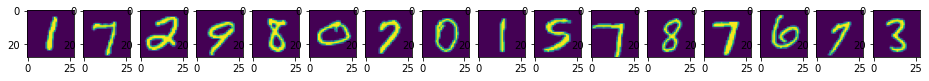

In [84]:
import random
import gzip
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


images_file = "t10k-images-idx3-ubyte.gz"


def read_mnist(data_dir, images_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return images


X = read_mnist(local_data_dir, images_file)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

# preprocess the data to be consumed by the model


def normalize(x, axis):
    eps = np.finfo(float).eps

    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std


samples = normalize(samples, axis=(1, 2))
samples = np.expand_dims(samples, axis=3)

In [85]:
predictions = predictor.predict(samples)["predictions"]

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)

print("Predictions: ", *predictions)

Predictions:  1 7 2 9 8 0 7 0 1 5 7 8 7 6 7 3


In [86]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: mnist-hp-tun-221231-1817-002-0d2f90c3
INFO:sagemaker:Deleting endpoint with name: mnist-hp-tun-221231-1817-002-0d2f90c3
